# [HW14] Multiple Logistic Regression



지난시간에 logistic regression에 대해서 데이터를 생성하여 실습을 진행하였습니다. 이번에는 실제 데이터를 사용해서 다양한 입력 변수가 있을 때 logistic regression을 진행해 보겠습니다. 


In [7]:
# visualization을 위한 helper code입니다.
if 'google.colab' in str(get_ipython()):
    print('Downloading plot_helpers.py to util/ (only neded for colab')
    !mkdir util; wget https://raw.githubusercontent.com/minireference/noBSLAnotebooks/master/util/plot_helpers.py -P util

--2021-08-30 09:52:28--  https://raw.githubusercontent.com/minireference/noBSLAnotebooks/master/util/plot_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8787 (8.6K) [text/plain]
Saving to: ‘util/plot_helpers.py’

plot_helpers.py     100%[===================>]   8.58K  --.-KB/s    in 0s      

2021-08-30 09:52:28 (81.5 MB/s) - ‘util/plot_helpers.py’ saved [8787/8787]



## 1.1 Images of metal-casting parts

제조업 분야에서 물품의 상태를 판별하는데 컴퓨터 비전을 많이 사용합니다. 물품의 사진이 주어지면 우리가 학습한 모델은 그것이 결함이 있는지 없는지 판단합니다. 우리는 이것을 multiple logistic regression으로 진행해보겠습니다. 

우리는 간단한 실험으로 하기 위해서 이미지를 흑백으로 변환하고, 개수를 적게 진행하겠습니다. 

필요한 패키지를 import 하고, 첨부되어있는 데이터 파일을 통해 데이터를 불러오겠습니다. 


In [8]:
from autograd import numpy
from autograd import grad
from matplotlib import pyplot

In [9]:
from urllib.request import urlretrieve
URL = 'https://github.com/engineersCode/EngComp6_deeplearning/raw/master/data/casting_images.npz'
urlretrieve(URL, 'casting_images.npz')

('casting_images.npz', <http.client.HTTPMessage at 0x7f84f46cbc50>)

In [10]:
# read in images and labels
with numpy.load("/content/casting_images.npz", allow_pickle=True) as data:
    ok_images = data["ok_images"]
    def_images = data["def_images"]

In [11]:
type(ok_images)

numpy.ndarray

In [12]:
ok_images.shape

(519, 16384)

519는 우리의 전체 데이터의 개수입니다. 

원래 데이터는 128 * 128 사이즈의 이미지 데이터입니다. 그런데 우리는 그것을 하나로 쭉 펴서 다룰 것이기 때문에 16384가 되었습니다. 

이제 우리의 데이터셋이 어떻게 구성되어있는지 한번 자세히 알아보겠습니다. 

In [13]:
n_ok_total = ok_images.shape[0]
res = int(numpy.sqrt(def_images.shape[1]))

print("Number of images without defects:", n_ok_total)
print("Image resolution: {} by {}".format(res, res))

Number of images without defects: 519
Image resolution: 128 by 128


In [14]:
n_def_total = def_images.shape[0]
print("Number of images with defects:", n_def_total)

Number of images with defects: 781


결함이 없는 이미지는 519개, 결함이 있는 이미지는 781개 입니다. 이제 pyplot 패키지를 통해서 이미지를 보겠습니다. 

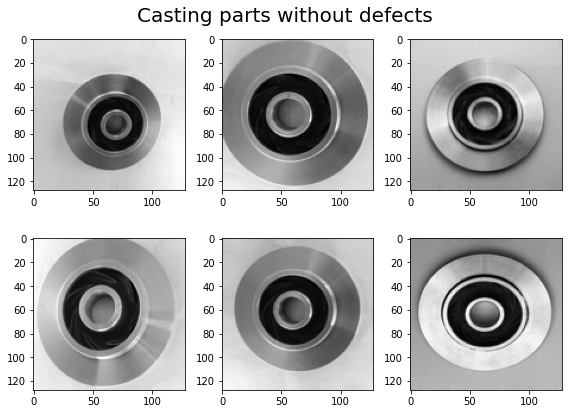

In [15]:
fig, axes = pyplot.subplots(2, 3, figsize=(8, 6), tight_layout=True)
axes[0, 0].imshow(ok_images[0].reshape((res, res)), cmap="gray")
axes[0, 1].imshow(ok_images[50].reshape((res, res)), cmap="gray")
axes[0, 2].imshow(ok_images[100].reshape((res, res)), cmap="gray")
axes[1, 0].imshow(ok_images[150].reshape((res, res)), cmap="gray")
axes[1, 1].imshow(ok_images[200].reshape((res, res)), cmap="gray")
axes[1, 2].imshow(ok_images[250].reshape((res, res)), cmap="gray")
fig.suptitle("Casting parts without defects", fontsize=20);

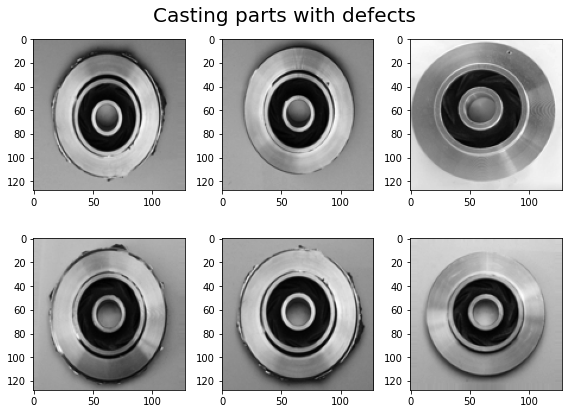

In [16]:
fig, axes = pyplot.subplots(2, 3, figsize=(8, 6), tight_layout=True)
axes[0, 0].imshow(def_images[0].reshape((res, res)), cmap="gray")
axes[0, 1].imshow(def_images[50].reshape((res, res)), cmap="gray")
axes[0, 2].imshow(def_images[100].reshape((res, res)), cmap="gray")
axes[1, 0].imshow(def_images[150].reshape((res, res)), cmap="gray")
axes[1, 1].imshow(def_images[200].reshape((res, res)), cmap="gray")
axes[1, 2].imshow(def_images[250].reshape((res, res)), cmap="gray")
fig.suptitle("Casting parts with defects", fontsize=20);

## 1.2 Multiple logistic regression

지난 시간에 logistic regression을 배우면서 logistic function을 같이 배웠습니다. Logistic function은 출력 값이 0과 1 사이의 확률 값이 되도록 변환해주는 함수입니다. 그래서 지금 같이 분류해야할 class가 2개 일 때 많이 사용합니다. 

지난 시간과 이번의 차이점은 지난번에는 입력 변수가 1개였다면 이번에는 여러개의 입력 변수가 있습니다. 수식을 통해서 알아보도록 하겠습니다. 

$$\hat{y}^{(1)} = \text{logistic}(b + w_1x_1^{(1)}+ w_2x_2^{(1)} + ... + w_nx_n^{(1)})$$
$$\hat{y}^{(2)} = \text{logistic}(b + w_1x_1^{(2)}+ w_2x_2^{(2)} + ... + w_nx_n^{(2)})$$
$$\vdots$$
$$\hat{y}^{(N)} = \text{logistic}(b + w_1x_1^{(N)}+ w_2x_2^{(N)} + ... + w_nx_n^{(N)})$$

위 식에서 $(1), (2), ... (N)$은 $N$개의 이미지가 있다는 것입니다. $\hat{y}$는 예측한 확률 값입니다. 

위의 수식들을 행렬의 형태로 바꾸면 다음과 같이 바꿀 수 있습니다. 

$$
\begin{bmatrix}
\hat{y}^{(1)} \\
\vdots        \\
\hat{y}^{(N)}
\end{bmatrix} 
= 
\text{logistic} \left(
\begin{bmatrix}
b             \\
\vdots        \\
b
\end{bmatrix}
+
\begin{bmatrix}
x_1^{(1)} & \cdots & x_n^{(1)} \\
\vdots    & \ddots & \vdots    \\
x_1^{(N)} & \cdots & x_n^{(N)} 
\end{bmatrix}
\begin{bmatrix}
w_1             \\
\vdots        \\
w_n
\end{bmatrix}
\right)
$$

$$\hat{\mathbf{y}} = \text{logistic}(\mathbf{b} + \mathbf{X} \mathbf{w})$$

이제 코드를 통해서 알아보겠습니다. 



In [17]:
def logistic(x):
    """Logistic/sigmoid function.
    
    Arguments
    ---------
    x : numpy.ndarray
        The input to the logistic function.
    
    Returns
    -------
    numpy.ndarray
        The output.
        
    Notes
    -----
    The function does not restrict the shape of the input array. The output
    has the same shape as the input.
    """
    return 1. / (1. + numpy.exp(-x))

In [18]:
def logistic_model(x, params):
    """A logistic regression model.
    
    A a logistic regression is y = sigmoid(x * w + b), where the operator *
    denotes a mat-vec multiplication.
    
    Arguments
    ---------
    x : numpy.ndarray
        The input of the model. The shape should be (n_images, n_total_pixels).
    params : a tuple/list of two elemets
        The first element is a 1D array with shape (n_total_pixels). The
        second element is a scalar (the intercept)

    Returns
    -------
    probabilities : numpy.ndarray
        The output is a 1D array with length n_samples.
    """
    return logistic(numpy.dot(x, params[0]) + params[1])

이제 cost function을 만들겠습니다. Logistic regression 실습 시간에 배운 cost function을 사용하고, 16384개의 많은 feature들을 가지고 있기 때문에 지난시간에 배운 regularization term을 추가하도록 하겠습니다. 

$$\text{cost function} = -\sum_{i=1}^N y_{\text{true}}^{(i)} \log\left(\hat{y}^{(i)}\right) + \left( 1- y_{\text{true}}^{(i)}\right) \log\left(1-\hat{y}^{(i)}\right) + \lambda \sum_{i=1}^n w_i^2 $$

이것을 벡터꼴로 나타내면 다음과 같습니다. 

$$\text{cost function} = - [\mathbf{y}_{\text{true}}\log\left(\mathbf{\hat{y}}\right) + \left( \mathbf{1}- \mathbf{y}_{\text{true}}\right) \log\left(\mathbf{1}-\mathbf{\hat{y}}\right)] + \lambda \sum_{i=1}^n w_i^2 $$

여기서 $\mathbf{1}$는 1로 이루어진 벡터입니다. 

이것을 코드로 옮겨보겠습니다. 

In [19]:
def model_loss(x, true_labels, params, _lambda=1.0):
    """Calculate the predictions and the loss w.r.t. the true values.
    
    Arguments
    ---------
    x : numpy.ndarray
        The input of the model. The shape should be (n_images, n_total_pixels).
    true_labels : numpy.ndarray
        The true labels of the input images. Should be 1D and have length of
        n_images.
    params : a tuple/list of two elements
        The first element is a 1D array with shape (n_total_pixels). The
        second elenment is a scalar.
    _lambda : float
        The weight of the regularization term. Default: 1.0
    
    Returns
    -------
    loss : a scalar
        The summed loss.
    """
    pred = logistic_model(x, params)
    
    loss = - (
        numpy.dot(true_labels, numpy.log(pred+1e-15)) +
        numpy.dot(1.-true_labels, numpy.log(1.-pred+1e-15))
    ) + _lambda * numpy.sum(params[0]**2)
    
    return loss

## 1.3 Training, validation, and test datasets

우리가 모델을 학습하는 목적은 단순히 주어진 데이터셋을 잘 설명할 수 있는 것이 아닙니다. 주어진 데이터셋을 잘 설명하고, 그로 인해 학습 때 본 데이터가 아닌 새롭게 주어진 데이터에서 잘 예측을 할 수 있는 모델을 만드는 것입니다. 그래서 우리는 성능을 평가할 때 학습 때 보지 못한 데이터로 성능을 측정을 해야합니다. 그것이 우리의 최종 목적이기 때문입니다.

이것은 우리가 수능 공부를 하는 것과 비슷합니다. 우리는 학교 수업을 듣고, 수많은 문제집을 풀면서 공부를 합니다. 그 이유는 수능 때 좋은 성적을 얻기 위함입니다. 이처럼 우리는 수많은 문제집이라는 training data 로 학습을 하고 training data 에서 보지 못한 수능이라는 새로운 데이터에서 좋은 성능을 나타내는 것을 목표로 하고 있습니다. 

그래서 우리는 모델을 학습할 때 세가지로 데이터셋을 나누게 됩니다. **Training, validation, test** 로 나누게 됩니다. 학습을 할 때 training, validation 을 사용하고, 최종 성능을 test로 측정합니다. 

왜 2가지 training, test로만 평가하는 것이 아니라 validation까지 필요할까요?

저희는 한번도 보지 못한 test data에 대해서 잘 예측을 해야 합니다. 그러면 training 으로 학습을 하면서 이렇게 학습을 하면 새로운 데이터에 잘 예측을 할 수 있는지 확인을 해보고, 아니면 수정을 해야 합니다. 그래서 존재하는 것이 validation입니다. Training을 가지고 학습하는 과정에서 새로운 validation에서도 잘 작동을 하도록 학습을 해줍니다. 이것은 우리가 모의고사를 치르는 것과 유사합니다. 우리는 평소에 문제집을 풀 때 모의고사를 통해서 내 약점부위를 파악하고 앞으로 학습을 어떻게 할지 정하게 됩니다. 

이제 우리는 전체 데이터셋을 3종류로 나누도록 하겠습니다. 60%는 training, 20%는 validation, 마지막 20%는 test로 하겠습니다. 

코드를 통해서 분배해보겠습니다. 


In [20]:
# numbers of images for validation (~ 20%)
n_ok_val = int(n_ok_total * 0.2)
n_def_val = int(n_def_total * 0.2)
print("Number of images without defects in validation dataset:", n_ok_val)
print("Number of images with defects in validation dataset:", n_def_val)

# numbers of images for test (~ 20%)
n_ok_test = int(n_ok_total * 0.2)
n_def_test = int(n_def_total * 0.2)
print("Number of images without defects in test dataset:", n_ok_test)
print("Number of images with defects in test dataset:", n_def_test)

# remaining images for training (~ 60%)
n_ok_train = n_ok_total - n_ok_val - n_ok_test
n_def_train = n_def_total - n_def_val - n_def_test
print("Number of images without defects in training dataset:", n_ok_train)
print("Number of images with defects in training dataset:", n_def_train)

Number of images without defects in validation dataset: 103
Number of images with defects in validation dataset: 156
Number of images without defects in test dataset: 103
Number of images with defects in test dataset: 156
Number of images without defects in training dataset: 313
Number of images with defects in training dataset: 469


이제 numpy 패키지 안에 split 함수로 나누어줍니다. 

In [21]:
ok_images = numpy.split(ok_images, [n_ok_val, n_ok_val+n_ok_test], 0)
def_images = numpy.split(def_images, [n_def_val, n_def_val+n_def_test], 0)

이제 numpy 패키지 안에 concatenate 함수를 이용해서 train, val, test끼리 결함이 있는 이미지와 없는 이미지들을 합쳐줍니다. 

In [22]:
images_val = numpy.concatenate([ok_images[0], def_images[0]], 0)
images_test = numpy.concatenate([ok_images[1], def_images[1]], 0)
images_train = numpy.concatenate([ok_images[2], def_images[2]], 0)

## 1.4 Data normalization: z-score normalization

지난 시간에 했던 것처럼 다양한 feature가 있으면 normalization을 해주어야 합니다. 이번에는 z-score normalization을 사용하겠습니다. 

$$z = \frac{x - \mu_\text{train}}{\sigma_\text{train}}$$

Train, validation, test 모두 진행해주겠습니다. 

In [23]:
# calculate mu and sigma
mu = numpy.mean(images_train, axis=0)
sigma = numpy.std(images_train, axis=0)

# normalize the training, validation, and test datasets
images_train = (images_train - mu) / sigma
images_val = (images_val - mu) / sigma
images_test = (images_test - mu) / sigma

## 1.5 Creating labels/classes

이제 데이터셋에 class label을 정해주어야 합니다. 이 이미지가 결함이 있는지 없는지 명시적으로 나타내주는 것입니다. 

결함이 있는 것을 1, 결함이 없는 것을 0으로 나타내어 주겠습니다. 

In [24]:
# labels for training data
labels_train = numpy.zeros(n_ok_train+n_def_train)
labels_train[n_ok_train:] = 1.

# labels for validation data
labels_val = numpy.zeros(n_ok_val+n_def_val)
labels_val[n_ok_val:] = 1.

# labels for test data
labels_test = numpy.zeros(n_ok_test+n_def_test)
labels_test[n_ok_test:] = 1.

이제 입력으로 들어온 이미지에 결함이 있는지 없는지 알아내기 위해 logistic model을 사용하겠습니다. 

지난 시간에 한 것처럼 출력 확률 값이 0.5보다 크면 결함이 있고, 0.5보다 작으면 결함이 없다고 하겠습니다. 

In [25]:
def classify(x, params):
    """Use a logistic model to label data with 0 or/and 1.
    
    Arguments
    ---------
    x : numpy.ndarray
        The input of the model. The shape should be (n_images, n_total_pixels).
    params : a tuple/list of two elements
        The first element is a 1D array with shape (n_total_pixels). The
        second element is a scalar.
    
    Returns
    -------
    labels : numpy.ndarray
        The shape of the label is the same with `probability`.
    
    Notes
    -----
    This function only works with multiple images, i.e., x has a shape of
    (n_images, n_total_pixels).
    """
    probabilities = logistic_model(x, params)
    labels = (probabilities >= 0.5).astype(float)
    return labels

## 1.6 Evaluating model performance : F-score, Accuracy

이제 우리가 학습한 모델이 얼마나 잘 예측을 하는지 알아보도록 하겠습니다. 

우리가 예측한 것의 결과는 다음 4가지의 종류로 분류할 수 있습니다. 

1. True Positive(TP) : 결함이 있다고 예측한 것들 중 실제로 결함이 있는 것
2. False Positive(FP) : 결함이 있다고 예측한 것들 중 실제로 결함이 없는 것
3. True Negative(TN) : 결함이 없다고 예측한 것들 중 실제로 결함이 없는 것
4. False Negative(FN) : 결함이 없다고 예측한 것들 중 실제로 결함이 있는 것

|                     |결함이 있다고 예측  | 결함이 없다고 예측  |
|---                  |---                 |---                  |
|실제로 결함이 있음   | $$N_{TP}$$         |    $$N_{FN}$$       |
|실제로 결함이 없음   |   $$N_{FP}$$       |   $$N_{TN}$$        | 

위에서 $N$은 개수를 나타냅니다. 

이제 위에서 설명한 것들을 가지고 가장 보편적으로 사용하는 지표 3가지를 알아보도록 하겠습니다. 

$$\text{accuracy} = \frac{\text{정확하게 예측한 개수}}{\text{예측한 전체 개수}} \frac{N_{TP} + N_{TN}}{N_{TP}+N_{FN}+N_{FP}+N_{TN}}$$
$$\text{precision} = \frac{\text{결함이 있다고 정확하게 예측한 개수}}{\text{결함이 있다고 예측한 총 개수}} = \frac{N_{TP}}{N_{TP}+N_{FP}}$$
$$\text{recall} = \frac{\text{결함이 있다고 정확하게 예측한 개수}}{\text{실제로 결함이 있는 개수}} =\frac{N_{TP}}{N_{TP}+N_{FN}}$$

여기서 우리는 precision과 recall로 F-score을 계산할 수 있습니다. 

$$\text{F-score} = \frac{(1+\beta^2) \text{precision} \times \text{recall}}{\beta^2 \text{precision} + \text{recall}}$$

$\beta$는 precision과 recall중 어떤 것을 중점적으로 생각할지에 대한 저희가 정하는 상수입니다. 

이제 accuracy와 f1-score을 구하는 것을 코드로 구현해보겠습니다. 

In [26]:
def performance(predictions, answers, beta=1.0):
    """Calculate precision, recall, and F-score.
    
    Arguments
    ---------
    predictions : numpy.ndarray of integers
        The predicted labels.
    answers : numpy.ndarray of integers
        The true labels.
    beta : float
        A coefficient representing the weight of recall.
    
    Returns
    -------
    precision, recall, score, accuracy : float
        Precision, recall, and F-score, accuracy respectively.
    """
    true_idx = (answers == 1)  # the location where the answers are 1
    false_idx = (answers == 0)  # the location where the answers are 0
    
    # true positive: answers are 1 and predictions are also 1
    n_tp = numpy.count_nonzero(predictions[true_idx] == 1)
    
    # false positive: answers are 0 but predictions are 1
    n_fp = numpy.count_nonzero(predictions[false_idx] == 1)
    
    # true negative: answers are 0 and predictions are also 0
    n_tn = numpy.count_nonzero(predictions[false_idx] == 0)
    
    # false negative: answers are 1 but predictions are 0
    n_fn = numpy.count_nonzero(predictions[true_idx] == 0)
    
    # precision, recall, and f-score
    precision = n_tp / (n_tp + n_fp)
    recall = n_tp / (n_tp + n_fn)
    score = (
        (1.0 + beta**2) * precision * recall / 
        (beta**2 * precision + recall)
    )

    accuracy = (n_tp + n_tn) / (n_tp + n_fn + n_fp + n_tn)

    return precision, recall, score, accuracy

두개 값 모두 높을수록 좋습니다.

## 1.7 Initialization

이제 저희가 학습할 parameter들을 초기화하겠습니다. 먼저 0으로 초기화해서 성능을 측정해보겠습니다. 

In [27]:
# a function to get the gradients of a logistic model
gradients = grad(model_loss, argnum=2)

# initialize parameters
w = numpy.zeros(images_train.shape[1], dtype=float)
b = 0.

학습 전, 후의 성능 비교를 위해 학습 전 test dataset 에서의 성능을 측정해보겠습니다. 

In [28]:
# initial accuracy
pred_labels_test = classify(images_test, (w, b))
perf = performance(pred_labels_test, labels_test)

print("Initial precision: {:.1f}%".format(perf[0]*100))
print("Initial recall: {:.1f}%".format(perf[1]*100))
print("Initial F-score: {:.1f}%".format(perf[2]*100))
print("Initial Accuracy: {:.1f}%".format(perf[3]*100))

Initial precision: 60.2%
Initial recall: 100.0%
Initial F-score: 75.2%
Initial Accuracy: 60.2%


0으로 초기화 했는데 성능이 나쁘지 않아 보입니다. 왜그럴까요? 

전체를 다 0으로 초기화 하게되면 우리 모델은 단순히 모든 것들이 다 결함이 있다고 예측을 하게 됩니다. 우리는 103개의 결함이 없는 부품, 156개의 결함이 있는 부품을 가지고 있기 때문에 성능이 괜찮아 보이는 것입니다. 마치 T/F 문제를 풀 때 모든 것을 F로 찍은 학생이 F 가 정답인 문제의 개수가 많을 때 높은 점수를 받는 것과 비슷한 것입니다. 

Test와 validation set은 우리의 현실 데이터와 비슷해야 합니다. 실제 제조 공정에서 결함이 있는 부품들이 저렇게 많지 않을 것이기 때문에 이는 좋은 데이터라고 볼 수 없습니다. 데이터셋을 구성하는 데에는 그 해당 도메인에 대한 지식이 들어가야 합니다. 

하지만 우리는 실습을 진행중이기 때문에 이대로 진행하겠습니다. 



## 1.7 Training / optimization 

이제 본격적으로 학습을 진행하도록 하겠습니다. 학습을 진행하는 동안 validation data로 얼마나 학습이 잘 진행되고 있는지 확인하겠습니다. 그리고 validation loss 가 더이상 줄어들지 않는 부분에서 학습을 멈추도록 하겠습니다. 





In [29]:
# learning rate
lr = 1e-5

# a variable for the change in validation loss
change = numpy.inf

# a counter for optimization iterations
i = 0

# a variable to store the validation loss from the previous iteration
old_val_loss = 1e-15

# keep running if:
#   1. we still see significant changes in validation loss
#   2. iteration counter < 10000
while change >= 1e-5 and i < 10000:
    
    # calculate gradients and use gradient descents
    grads = gradients(images_train, labels_train, (w, b))
    w -= (grads[0] * lr)
    b -= (grads[1] * lr)
    
    # validation loss
    val_loss = model_loss(images_val, labels_val, (w, b))
    
    # calculate f-scores against the validation dataset
    pred_labels_val = classify(images_val, (w, b))
    score = performance(pred_labels_val, labels_val)

    # calculate the chage in validation loss
    change = numpy.abs((val_loss-old_val_loss)/old_val_loss)

    # update the counter and old_val_loss
    i += 1
    old_val_loss = val_loss
    
    # print the progress every 10 steps
    if i % 10 == 0:
        print("{}...".format(i), end="")

print("")
print("")
print("Upon optimization stopped:")
print("    Iterations:", i)
print("    Validation loss:", val_loss)
print("    Validation precision:", score[0])
print("    Validation recall:", score[1])
print("    Validation F-score:", score[2])
print("    Validation Accuracy:", score[3])
print("    Change in validation loss:", change)

10...20...30...40...50...60...70...80...90...100...110...120...130...140...150...160...170...180...190...200...210...220...230...240...250...260...270...280...290...300...310...320...330...340...350...360...370...380...390...400...410...420...430...440...450...460...470...480...490...500...510...520...530...540...

Upon optimization stopped:
    Iterations: 541
    Validation loss: 126.77255420521098
    Validation precision: 0.900709219858156
    Validation recall: 0.8141025641025641
    Validation F-score: 0.8552188552188552
    Validation Accuracy: 0.833976833976834
    Change in validation loss: 1.691256849174652e-06


최종 성능은 Test dataset으로 측정해야합니다! 이제 우리의 최종 성능을 구해보겠습니다.  

In [30]:
# final accuracy
pred_labels_test = classify(images_test, (w, b))
perf = performance(pred_labels_test, labels_test)

print("Final precision: {:.1f}%".format(perf[0]*100))
print("Final recall: {:.1f}%".format(perf[1]*100))
print("Final F-score: {:.1f}%".format(perf[2]*100))
print("Final Accuracy: {:.1f}%".format(perf[3]*100))

Final precision: 88.0%
Final recall: 84.6%
Final F-score: 86.3%
Final Accuracy: 83.8%


F-score는 75.2%에서 86.2%, accuracy는 60.2%에서 83.8% 로 많이 증가하였습니다! 

학습이 잘 된것을 확인할 수 있습니다!

[HW10]부터 [HW14]에 걸쳐서 Linear model을 통해서 학습을 하는 방법을 배웠습니다. 

다음 시간은 competition입니다. 제가 드린 데이터를 가지고 test set에서 가장 좋은 성능을 내는 사람이 우승하는 방식입니다. 

궁금한 점 있으시면 질문 주시고 수고 많으셨습니다! 